In [1]:
source('functions.R')

DATASET_FILENAME = './combined.csv'
OUTPUT_FIELD = "satisfactionv2"

MYLIBRARIES<-c("outliers",
               "corrplot",
               "formattable",
               "stats",
               "caret",
               "PerformanceAnalytics",
               "stringr",
               "partykit",
               "C50",
               "randomForest",
               #"keras",
               "h2o")

install.packages('e1071')
library(caret)
library(e1071)
library(randomForest)
library(datasets)
library(caret)
# ************************************************
# This is where R starts execution

# Automatically release memory
gc()

# Tries to clear plots and other graphics in RStudio output
if(!is.null(dev.list())) dev.off()
graphics.off()

# This clears all warning messages
#assign("last.warning", NULL, envir = baseenv())

# clears the RStudio console area
cat("\014")

# If library not already on your computer this will download and
# install the library. Each library is activated.
library(pacman)
pacman::p_load(char=MYLIBRARIES,install=TRUE,character.only=TRUE)

Warning message in install.packages("e1071"):
“installation of package ‘e1071’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: ggplot2

Loading required package: lattice

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2299105,122.8,4481058,239.4,3645185,194.7
Vcells,3936763,30.1,8388608,64.0,7470819,57.0


null device 
          1

In [58]:
OUTPUT_FIELD = "satisfactionv2"
processed_training<- NreadDataset('processed.csv')

# remmove unwanted fields
p<-c("X")#,"DepartureDelayinMinutes0" ,"DepartureDelayinMinutes1","DepartureDelayinMinutes2","DepartureDelayinMinutes3","ArrivalDelayinMinutes0",
   # "ArrivalDelayinMinutes1","ArrivalDelayinMinutes2","ArrivalDelayinMinutes3")

processed_training<-processed_training[,names(processed_training [-which(names(processed_training)%in% p)])]


select_field<-c('satisfactionv2',
#                'Gender',
                'CustomerType',
                'TypeofTravel',
                'ClassBusiness',
                'ClassEco',
                'ClassEcoPlus',
#                 'DepartureDelayinMinutes0',
#                 'DepartureDelayinMinutes1',
#                 'DepartureDelayinMinutes2',
#                 'DepartureDelayinMinutes3',
#                 'ArrivalDelayinMinutes0',
#                 'ArrivalDelayinMinutes1',
#                 'ArrivalDelayinMinutes2',
#                 'ArrivalDelayinMinutes3',
                'Age',
                'Seatcomfort',
                'DepartureArrivaltimeconvenient',
                'Foodanddrink',
                'Gatelocation',
                'Inflightwifiservice',
                'Inflightentertainment',
                'EaseofOnlinebooking',
                'Onboardservice',
                'Legroomservice',
                'Baggagehandling',
                'Checkinservice',
                'Cleanliness',
                'Onlineboarding')

print("Select Fields")
print(select_field)

processed_training<-processed_training[,select_field]
processed_training<-processed_training[sample(nrow(processed_training)),]
training_records<-round(nrow(processed_training)*(70/100))
training_data <- processed_training[1:training_records,]
testing_data <- processed_training[-(1:training_records),]

print(paste("Number of Training",nrow(training_data)))
print(paste("Number of Testing",nrow(testing_data)))


[1] "CSV dataset processed.csv has been read. Records= 259760"
[1] "Select Fields"
 [1] "satisfactionv2"                 "CustomerType"                  
 [3] "TypeofTravel"                   "ClassBusiness"                 
 [5] "ClassEco"                       "ClassEcoPlus"                  
 [7] "Age"                            "Seatcomfort"                   
 [9] "DepartureArrivaltimeconvenient" "Foodanddrink"                  
[11] "Gatelocation"                   "Inflightwifiservice"           
[13] "Inflightentertainment"          "EaseofOnlinebooking"           
[15] "Onboardservice"                 "Legroomservice"                
[17] "Baggagehandling"                "Checkinservice"                
[19] "Cleanliness"                    "Onlineboarding"                
[1] "Number of Training 181832"
[1] "Number of Testing 77928"


In [105]:
# Function from lab
myModelFormula<-function(dataset,fieldNameOutput,selectField){
     
  inputs<-paste(names(dataset)[which(names(dataset)!=fieldNameOutput )],collapse = "+")

  output<-paste(fieldNameOutput,"~")

  formular=as.formula(paste(output,inputs))

  return(formular)

} 
# modified function from lab
eval_logistic<-function(threshold,probs, gt_label){
    

    pred_label<-ifelse(as.numeric(probs)<threshold,0,1)
    # Confusion matrix table
    cm<-table(factor(pred_label,levels=0:1), factor(gt_label, levels=0:1))
    # True positive
    TP<-as.double(cm[2,2])
    # False Negative 
    FN<-as.double(cm[1,2])
    # False Positive 
    FP<-as.double(cm[2,1])
    # True Negative 
    TN<-as.double(cm[1,1])
    
    # accuracy
    acc<- 100.0 *((TP+TN)/(TP+FP+FN+TN))
    
    # precision
    pgood<-100.0*(TP/(TP+FP))
    pbad<-100.0*(TN/(FN+TN))
    # False positive rate
    FPR<-100.0*(FP/(FP+TN))
    # True positive rate OR RECALL
    TPR<-100.0*(TP/(TP+FN))
    # True negative rate 
    TNR<-100.0*(TN/(FP+TN))
    #  Mathhew's Correlation Coefficient
    MCC<-((TP*TN)-(FP*FN))/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    
   
    output<- list("TP"=TP,
                  "FN"=FN, 
                  "FP"=FP,
                  "TN"=TN, 
                  "acc"=acc,
                  "pgood"=pgood,
                  "pbad"=pbad,
                  "FPR"=FPR,
                  "TPR"=TPR,
                  "TNR"=TNR,
                  "MCC"=MCC)
    
    return(output)
}
roc_plot<-function(probs,gt){
    
    library(pROC)
    
    
    roc_score=roc(gt, probs) #AUC score
    auc = (roc_score$auc) #  area under curve 
    sensitivity <-roc_score$sensitivities
    specificity <-roc_score$specificities
    thresholds <-roc_score$thresholds
    
    plot(1-specificity,sensitivity,type='l', lwd=3, main ="ROC curve -- Logistic Regression ", col="red",xlab="False Positive Rate", ylab="True Positive Rate")
    abline(c(0,0),c(1,1),col="black",lty=3,lwd=2)

    auc_legend = paste("AUC = ", auc)
   legend("bottom",c(auc_legend,'Random Classifier'), col=c("red",'black'),lty=c('solid','dashed') ,ity=1:2, lwd=2)


    
   return(auc) 
}

LogisticCoeff_plot<-function(model){
    
# Plotting sorted model coefficient in barplot 
par(las=2) # make label text perpendicular to axis
par(mar=c(10,2,2,2)) # increase y-axis margin.
options(repr.plot.width = 10, repr.plot.height = 10)
coeff<-model$coeff[-which(names(model$coeff)%in%c('(Intercept)'))]
barplot(unname(sort(coeff)), main="Distribution of Logistic Regression Coefficient", names.arg=names(sort(coeff)), cex.names=.9, col=rgb(0.2,0.4,0.6,0.6) )

}

Performance_plot<-function(probs,testing_data){

  toPlot<-data.frame()

  #Test with vary Threshold values
  for(threshold in seq(0,1,by=0.01)){
   
    results<-eval_logistic(threshold,probs,testing_data)

    toPlot<-rbind(toPlot,data.frame(x=threshold,fpr=results$FPR,tpr=results$TPR))
  }

  toPlot$youdan<-toPlot$tpr+(1-toPlot$fpr)-1

  # Q25 use which.max() to return a single index to the higest value in the vector
  maxYoudan<-toPlot$x[which.max(toPlot$youdan)]

  toPlot$distance<-sqrt(((100-toPlot$tpr)^2)+(toPlot$fpr^2))

  minEuclidean<-toPlot$x[which.min(toPlot$distance)]

  plot(x=toPlot$x,y=toPlot$tpr, type="l",col="blue",
       xlab="Threshold",
       ylab="%Rate",
       main="Threshold Perfomance Satisfaction Model")

  # Plot the Euclidean distance to "perfect" classifier (smallest the best)
  lines(toPlot$x,toPlot$distance,type="l",col="green",lwd=2,lty=3)
  abline(v=minEuclidean,col="green",lty=3,lwd=2)

  # Plot the specificity (1-FPR)
  lines(x=toPlot$x,y=100-toPlot$fpr,type="l",col="red",lwd=3,lty=1)

  # The point where specificity and sensitivity are the same
  crosspoint<-toPlot$x[which(toPlot$tpr<(100-toPlot$fpr))[1]]
  abline(v=crosspoint,col="red",lty=3,lwd=2)

  # Q25 Plot Youdan distance
  lines(toPlot$x,toPlot$youdan,type="l",col="purple",lwd=2,lty=3)
  abline(v=maxYoudan,col="purple",lty=3,lwd=2)

  legend("bottom",c("TPR","1-FPR","Distance","Youdan"),col=c("blue","red","green","purple"),lty=1:2,lwd=2)
  text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean,"\nYoudan=",maxYoudan))

}

LogisticCurve_plot<-function(model, label){probability=
    
    label = ifelse(label==1,"satisfy","unsatisfy")
    print("Logistic Plot")
    df<-data.frame(probability = model$fitted.values,
                   satisfy = label)
 
    df <- df[order(df$probability, decreasing=FALSE),]
                                           
    
    df$rank <- 1:nrow(df)
                                           
    ggplot(data=df, aes(x=rank, y=probability)) +
      geom_point(aes(color=satisfy), alpha=1, shape=4, stroke=2) +
      xlab("Index of dataset") +
      ylab("Predicted probability of passenger satisfaction")+
      labs( title = "\n Logistic Regression Curve \n") 
    
    
}

In [93]:
LogisticRegressionModel<-function(training_data,testing_data,output){

formular<-myModelFormula(training_data,output)
print("********Formula for Logistic Refression**********")
print(formular)
print("*************************************************")
    
# Logsitic Regression Model
logisticModel<-stats::glm(formular,data=training_data,family=quasibinomial)
    
    
y_train<-training_data[,OUTPUT_FIELD]
    
#LogisticCurve_plot(logisticModel, y_train)

# Predict an satisfaction field for testing data (output is probabilites 0-1)
y_pred<- predict(logisticModel,testing_data,type="response")
    
gt<-testing_data[,OUTPUT_FIELD]
result<-eval_logistic(0.60,y_pred,gt)


    
# plot Metric
result$auc <-roc_plot(y_pred,gt)
Performance_plot(y_pred,gt)
LogisticCoeff_plot(logisticModel)
    
accuracy<-result$acc
precision<-result$pgood
recall<-result$TPR
auc <- result$auc
    
print(paste("ACCURACY : ", accuracy, ", PRECISION: ", precision, ", RECALL: ", recall, ", AUC : ",auc))
    
return(logisticModel)
}

[1] "********Formula for Logistic Refression**********"
satisfactionv2 ~ CustomerType + TypeofTravel + ClassBusiness + 
    ClassEco + ClassEcoPlus + Age + Seatcomfort + DepartureArrivaltimeconvenient + 
    Foodanddrink + Gatelocation + Inflightwifiservice + Inflightentertainment + 
    EaseofOnlinebooking + Onboardservice + Legroomservice + Baggagehandling + 
    Checkinservice + Cleanliness + Onlineboarding
<environment: 0x558e71ba6ae8>
[1] "*************************************************"


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



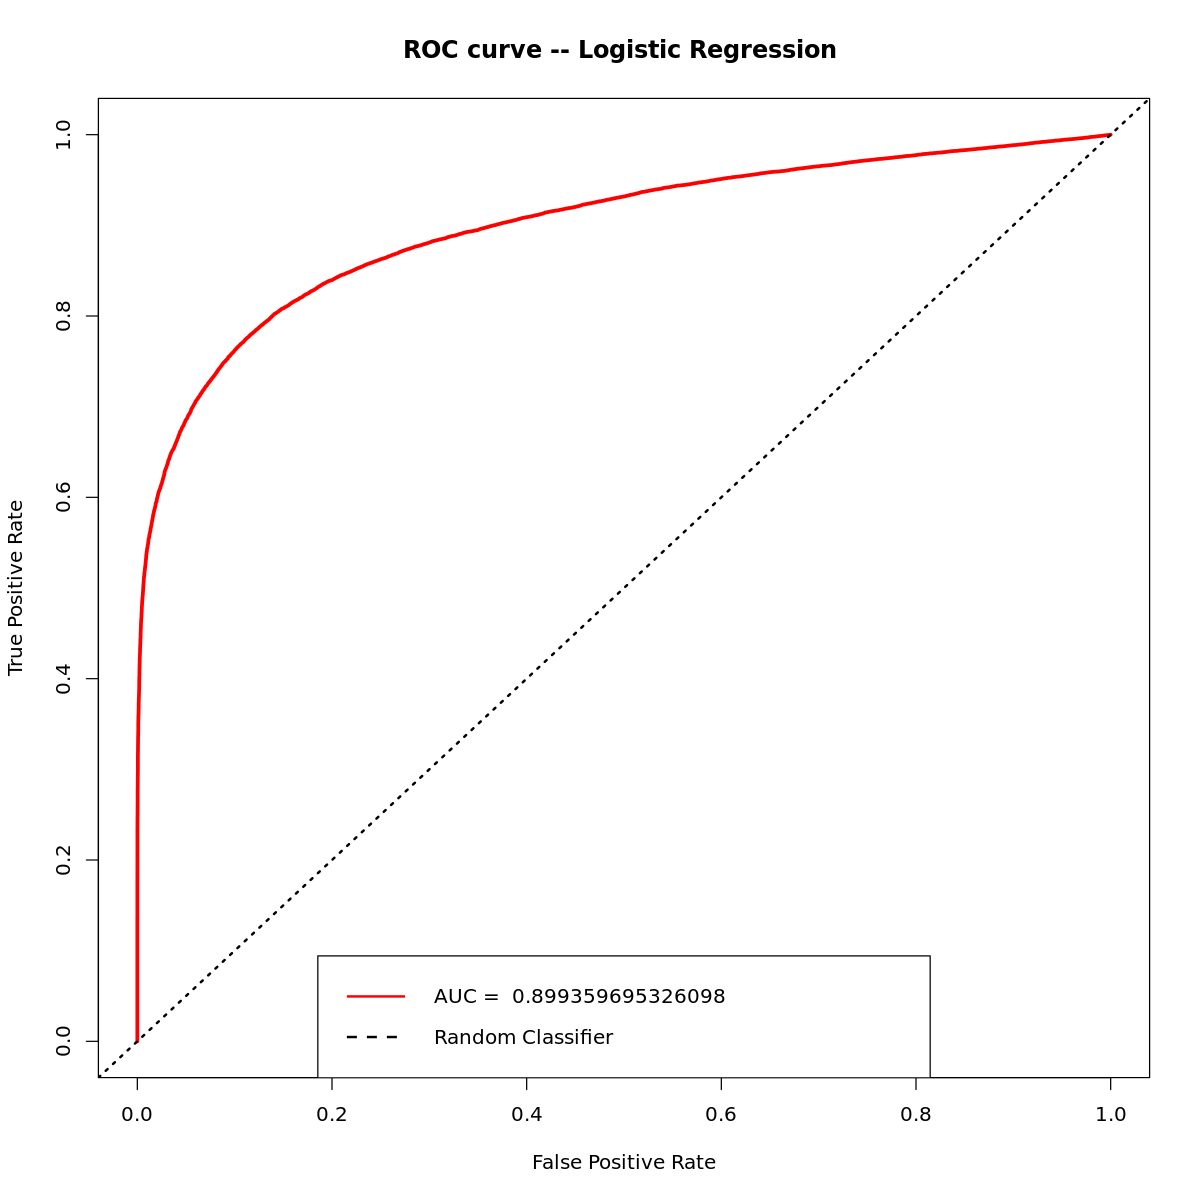

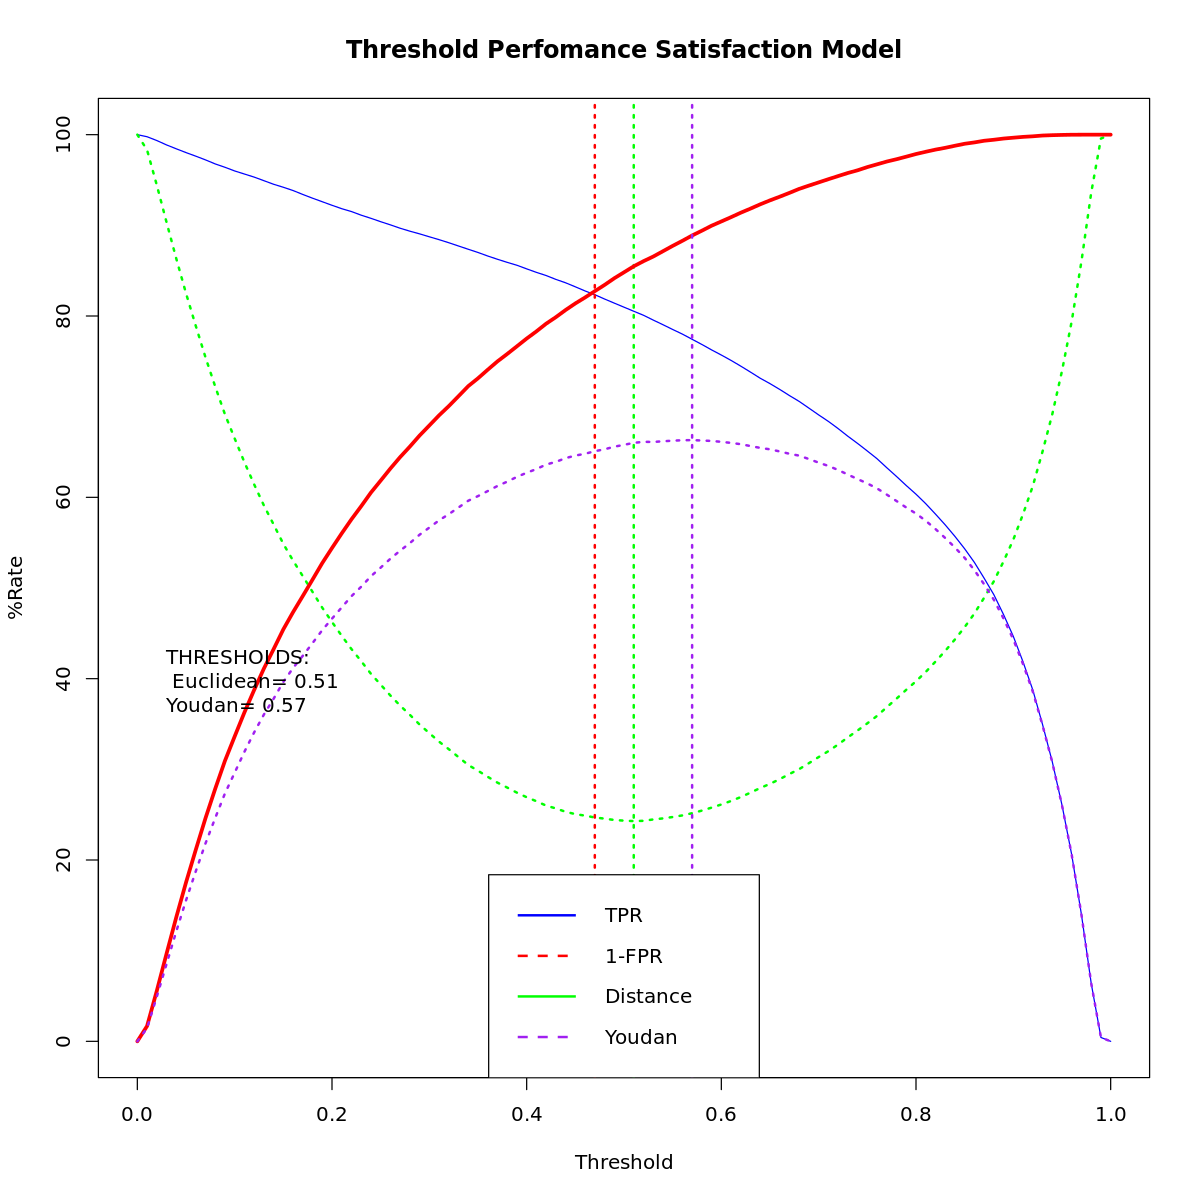

[1] "ACCURACY :  83.2152756390514 , PRECISION:  88.3520988863052 , RECALL:  75.6933158584535 , AUC :  0.899359695326098"


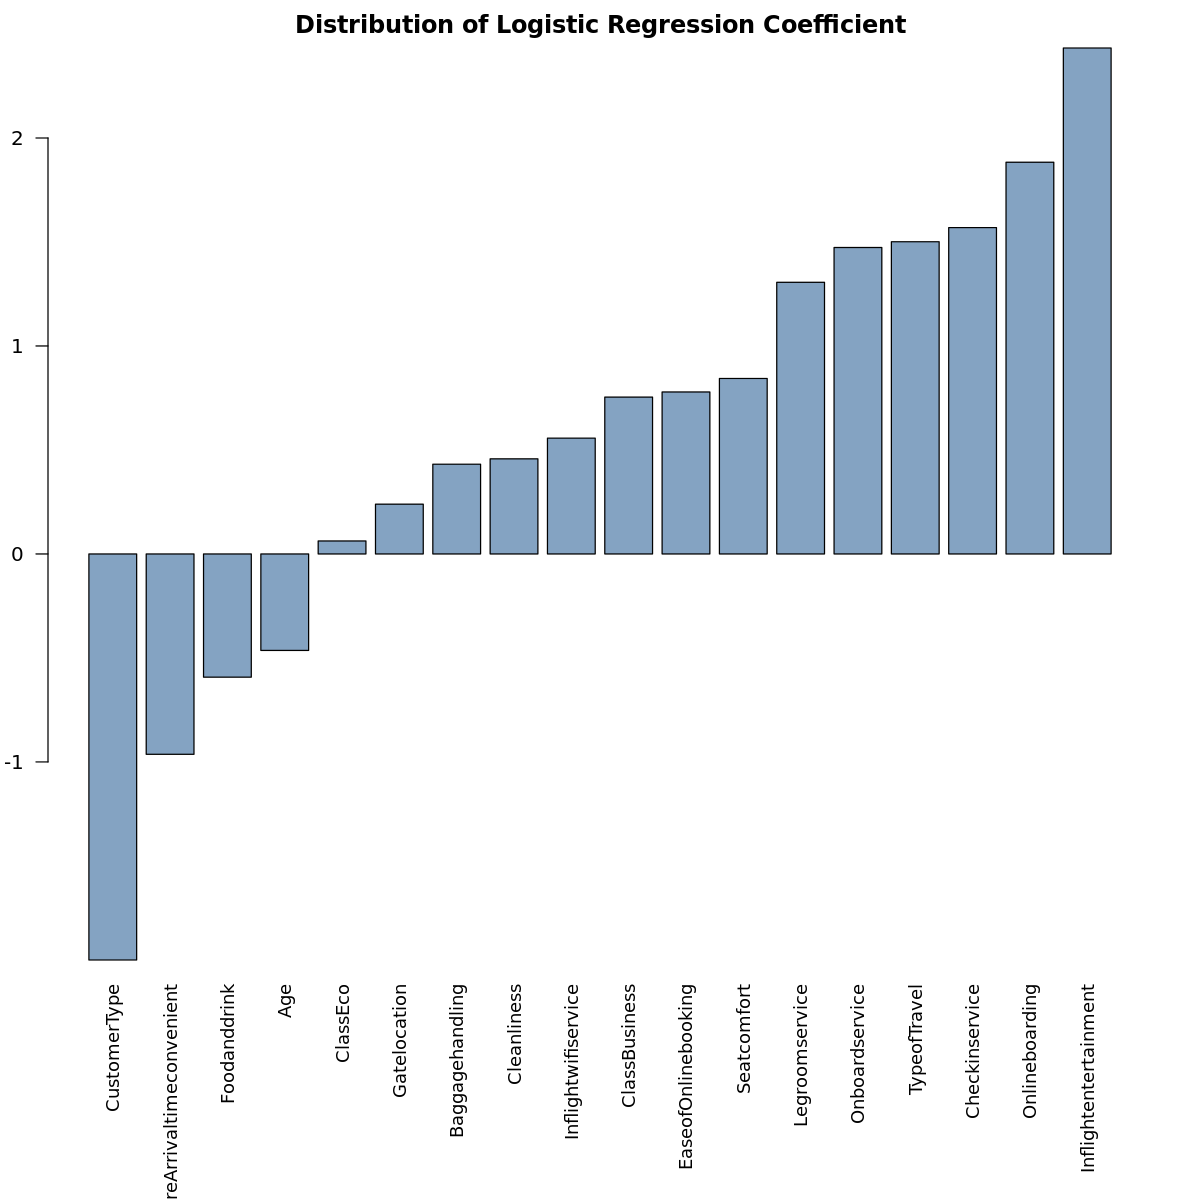

In [69]:
Lgm<-LogisticRegressionModel(training_data,testing_data,OUTPUT_FIELD)

[1] "Logistic Plot"


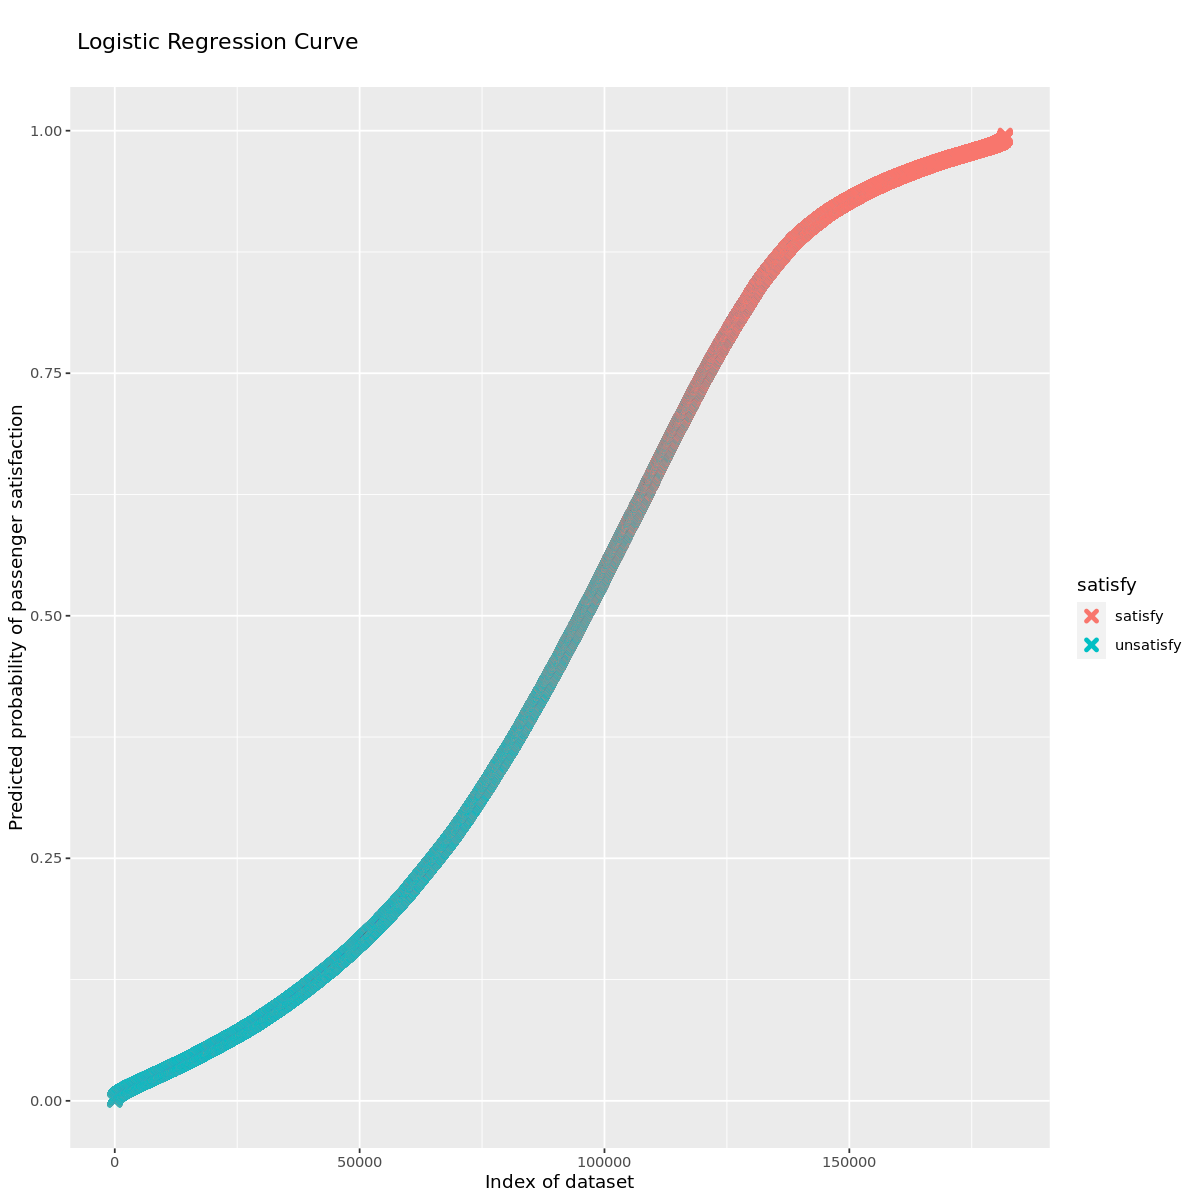

In [106]:
y_train<-training_data[,OUTPUT_FIELD]
LogisticCurve_plot(Lgm,y_train)

In [83]:
table(training_data$satisfactionv2)


    0     1 
92467 89365 